#EECS 504 PS3: Motion Magnification and Texture Synthesis

Please provide the following information 
(e.g. Andrew Owens, ahowens):

Elsa Mary Mathew, elmathew




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the notebook to your local machine as a .ipynb file for Canvas submission.

In [0]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import math

import random
import sys
from scipy import ndimage

# cv2.imshow does not work in Colab, we use cv2_imshow instead
from google.colab.patches import cv2_imshow

In [0]:
%%capture
# download some images
# should take a second to run

# for motion magnification problem
! wget -O bill.avi "https://drive.google.com/uc?export=download&id=1QR2dCShn-fYYEvcAQ8J4mnIo_ISqrjc7"

# for texture synthesis problem
! wget -O texture.jpg "https://drive.google.com/uc?export=download&id=11IlTZNLwfYsXQt2L1GbKdNqcj6JNkQik"
! wget -O rings.jpg "https://drive.google.com/uc?export=download&id=1fYtmQe_a40BWg1OU178SFbcU4KRZuphn"
! wget -O third_image.jpg "https://cdn.pixabay.com/photo/2014/09/24/16/28/bricks-459299__340.jpg"

## **Problem 3.1 (a)**

In [0]:
def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

In [0]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4;

# horizontal movement from (0, 0) to (0, 1)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1

ff1 = fftshift(fft2(im1))
ff2 = fftshift(fft2(im2))

### This is a quick tutorial for those who are not familiar with complex numbers in python.

In [5]:
# create a complex number
x = 1 + 1j
print("x =", x)
print("x.real", x.real, "x.imag", x.imag)

# magnitude and phase of complex number
mag = abs(x)
phase = angle(x)

print("Magnitude", mag)
print("Phase", phase)

# Euler's formula
y = mag * exp(phase * 1j)
print("y =", y)

x = (1+1j)
x.real 1.0 x.imag 1.0
Magnitude 1.4142135623730951
Phase 0.7853981633974483
y = (1.0000000000000002+1j)


In [0]:
def magnify_change(im1, im2, magnification_factor):
    
    # find phase shift in frequency domain
    im1_dft = fft2(im1)
    im2_dft = fft2(im2)
    phase_shift = angle(im2_dft)-angle(im1_dft)
    
    
    # magnify the phase change in frequency domain 
    #magnified_dft =abs(im1_dft)*exp((angle(im1_dft)+(magnification_factor*phase_shift))*1j)
    magnified_dft = abs(im2_dft) * exp((magnification_factor*phase_shift + angle(im1_dft)) * 1j)
    
    # what does the magnified phase change cause in image space?
    magnified = ifft2(magnified_dft).real
    
    return magnified

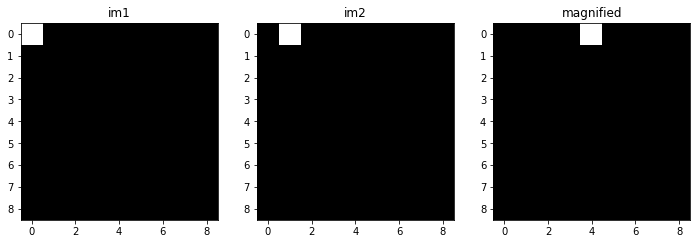

In [13]:
# magnify position change magnification_factor
magnification_factor=4
magnified = magnify_change(im1, im2, magnification_factor);

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');

## **Problem 3.1 (b)**


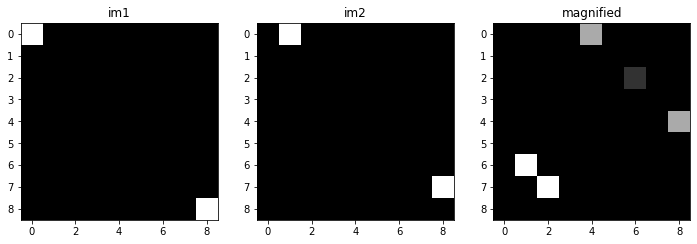

In [14]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# magnify position change
magnified = magnify_change(im1, im2, magnification_factor)


plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');


3.1 b)

 Since Phase is not a linear operation the method applied to detect motion does not work. Since one pixel moves in the horizontal direction while the other pixel moves in the vertical direction, on magnifying the motion by directly using phase shift we can see a wrap around image created i.e both pixels are magnified in both horizontal and vertical direction and two extra pixels can be observed in the final image


## **Problem 3.1 (c)**


Text(0.5, 1.0, 'magnified')

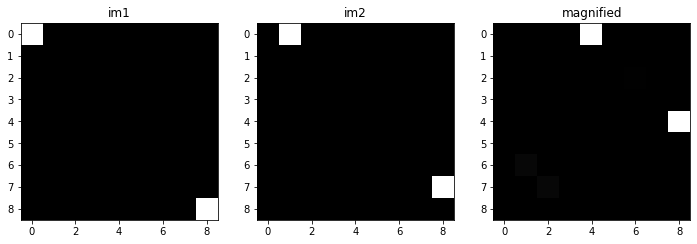

In [15]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# width of our Gaussian window
sigma = 2

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# we will magnify windows of the image and aggregate the results
magnified = np.zeros([im_size, im_size])

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(im_size), np.arange(im_size))
#print(X)
#print('\n')
#print(Y)


magnification_factor=4

d = np.sqrt(X*X+Y*Y)
for y in range(0, im_size, 2*sigma):
    for x in range(0, im_size, 2*sigma):
        
        gaussian_mask = (1/(2*math.pi*sigma))*np.exp(-( ((X-x)**2+(Y-y)**2) / ( 2.0 * sigma**2 ) ) )
        window_magnified = magnify_change(im1*gaussian_mask,im2*gaussian_mask,magnification_factor)
        magnified = magnified + window_magnified
        
plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified')

## **Problem 3.1 (d) - Motion Magnification**


In [16]:
import numpy as np
import cv2

cap = cv2.VideoCapture('bill.avi')

# list of video frames
frames = []

while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()
    
    if ret is False:
        break

    frame = cv2.resize(frame, (200, 200), interpolation=cv2.INTER_CUBIC)
    frames.append(frame)

cap.release()

# scale frame to 0-1
frames = np.array(frames) / 255.
print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

# get height, width
num_frames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

frames size: (60, 200, 200, 3) # (nb_frames, height, width, channel)


In [17]:
# 10x magnification of motion
magnification_factor = 10

# width of Gaussian window
sigma = 26

# alpha for moving average
alpha = 0.5

# we will magnify windows of the video and aggregate the results
magnified = np.zeros_like(frames)

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(width), np.arange(height))

# iterate over windows of the frames
x_range = list(range(0, width, 2*sigma))
y_range = list(range(0, height, 2*sigma))
num_windows = len(x_range) * len(y_range)
window_index = 1

for y in y_range:
    for x in x_range:
        for channel_index in range(3): # RGB channels
            for frame_index in range(num_frames):
                
                # create windowed frames
                gaussian_mask = ((1/(2*math.pi*sigma))*np.exp(-( ((X-x)**2+(Y-y)**2) / ( 2.0 * sigma**2 ) ) ))
                windowed_frames = gaussian_mask * frames[frame_index,:,:,channel_index]
            
                # initialize moving average of phase for current window/channel
                if frame_index == 0:
                    window_average_phase = angle(fft2(windowed_frames))
                
                window_dft = fft2(windowed_frames)
                
                # compute phase shift and constrain to [-pi, pi] since
                # angle space wraps around
                window_phase_shift = angle(window_dft) - window_average_phase
                window_phase_shift[window_phase_shift > pi] = window_phase_shift[window_phase_shift > pi] - 2 * pi
                window_phase_shift[window_phase_shift < -pi] = window_phase_shift[window_phase_shift < -pi] + 2 * pi
                
                # magnify phase shift
                window_magnified_phase = magnification_factor*window_phase_shift
                 
                # go back to image space
                window_magnified_dft = abs(window_dft)*exp((angle(window_dft)+window_magnified_phase)*1j)
                window_magnified = abs(ifft2(window_magnified_dft))
                
                # update moving average
                window_phase_unwrapped = window_average_phase + window_phase_shift
                window_average_phase = alpha * window_average_phase + (1 - alpha) * window_phase_unwrapped
                
                # aggregate
                magnified[frame_index,:,:,channel_index] = magnified[frame_index,:,:,channel_index] + window_magnified
        
        # print progress
        print('{}/{}'.format(window_index, num_windows))
        window_index += 1

1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
16/16


In [0]:
outputs = magnified / np.max(magnified)
for channel_index in range(3):
    original_frame = frames[0,:,:,channel_index]
    magnified_frame = outputs[0,:,:,channel_index]
    scale = np.std(original_frame[:]) / np.std(magnified_frame[:])
    original_mean = np.mean(original_frame[:])
    magnified_mean = np.mean(magnified_frame[:])
    outputs[:,:,:,channel_index] = magnified_mean + scale * (outputs[:,:,:,channel_index] - magnified_mean)

outputs = np.clip(outputs, 0, 1)

In [0]:
# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('bill_magnified.avi',fourcc, 30.0, (height, width))

for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = (np.clip(outputs[i], 0, 1) * 255).astype(np.uint8)
    
    # write frame to output video
    out.write(frame)

out.release()

In [0]:
# Only for colab downloading videos
try:
    from google.colab import files
    files.download('bill_magnified.avi')
except:
    print("Only for google colab")

## **Problem 3.2 - Texture Synthesis**

Note that the functions provided below are templates. Feel free to add your own helper functions as needed.

You can reference the pseudocode provided here:  https://people.eecs.berkeley.edu/~efros/research/NPS/alg.html.

### Find matches function

In [0]:
#Final Find Matches
def find_matches(template, sample, gauss_mask):
    ### parameters, as used by Efros and Leung
    epsilon = 0.1
    delta = 0.3

    
    window_size = template.shape[0]
    w = window_size//2
    s = sample.shape[0] - window_size + 1
    
    
    SSD = np.zeros((s*s))

    #### TODO:
    # valid_mask is a square mask of width window_size that is 1 where template is filled
    valid_mask = np.zeros((window_size, window_size))
    for i in range(window_size):
      for j in range(window_size):
        if template[i,j,0] !=0 or template[i,j,1] !=0 or template[i,j,2] !=0:
          valid_mask[i,j]=1 

    gauss_mask = gauss_mask*valid_mask
    mask = gauss_mask.reshape(window_size*window_size, 1) / np.sum(gauss_mask)


    #### TODO:
    # vectorized code that calculates SSD(template, sample)*mask for all patches
    template = template.reshape(window_size*window_size, 1, template.shape[2])
    
    stride_shape = window_size, window_size, s, s, sample.shape[2]
    s0, s1, s2 = sample.strides
    strides = s0, s1, s0, s1, s2
    
    sliding_win = np.lib.stride_tricks.as_strided(sample, shape=stride_shape, strides=strides)
    samp = sliding_win.reshape(window_size*window_size, s*s, sample.shape[2])
    dist = (template - samp)**2
    SSD = np.sum(np.sum(dist, axis=2)*mask, axis=0)
    
    # Return best matches
    ssd_min = np.min(SSD)
    
    SSD = SSD.reshape(s,s)
    pixellist = np.where(SSD <= ssd_min*(1+epsilon))
            
    return sample[pixellist[0] + w, pixellist[1] + w], SSD[pixellist]

    
    




### Synthesize texture function

In [0]:
def synth_texture(sample, window_size, out_size):
    # normalize pixel intensity

    sample = sample.astype(np.float64)
    sample = sample / 255.0
    seed_size = 3
    [sheight, swidth, channels] = sample.shape
    synth_img = np.zeros((*out_size, channels))

    # initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image
    rh = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    rw = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    center = [round(.5 * x) for x in out_size] # center
    synth_img[center[0]: center[0] + seed_size, center[1]: center[1] + seed_size ,:] = sample[rh: rh + seed_size , rw: rw + seed_size,:]

    # bitmap indicating filled pixels, the seed patch is initially filled
    filled = np.zeros(out_size)
    filled[center[0]: center[0] + seed_size , center[1]: center[1] + seed_size] = 1
    num_filled = int(np.sum(filled))
    n_pixels = out_size[0]*out_size[1]
    
    #initializing error threshold
    error_threshold = 0.3
    err_thresh_value = 0.3
    # TODO

    sigma = window_size/6.4
    G=gkern(window_size,sigma)
  

    # main loop: repeat until all pixels are filled
    next_p = n_pixels / 10
    while(num_filled < n_pixels):
        # report progress
        progress=0
        if(num_filled > next_p):
            print(round(100 * num_filled / n_pixels), '% complete')
            next_p += n_pixels / 10

        # TODO:
        # get list of unfilled pixels as (x, y) coordinates
        # hint: use dilation and masking to efficiently find unfilled neighboring pixels

        pixel_list=GetUnfilledNeighbors(filled,window_size)

        # TODO:
        # (optional, but recommended) randomly permute and sort list of pixels decreasing number of filled neighbor pixels
        #randomly permute candidate pixels
        pixel_list=np.random.permutation(pixel_list)
  
        # TODO:
        # iterate over the list of pixels
        w=window_size//2 
        for x, y in pixel_list:
          # calculating synthimg indices to account for border conditions
      

          #synthimg indices
          s_maxx = min(x + w + 1, out_size[0])
          s_minx = max(x - w,    0)
          s_maxy = min(y + w + 1, out_size[1])
          s_miny = max(y - w,    0)

          #template indices
          t_maxx = window_size - (x + w + 1 - s_maxx)
          t_minx = 0 - (x - w - s_minx)
          t_maxy = window_size - (y + w + 1 - s_maxy)
          t_miny = 0 - (y - w - s_miny)

          # TODO:
          # place window with center as (x, y) and use as template
          template = np.zeros((window_size, window_size, channels))
          template[t_minx : t_maxx, t_miny : t_maxy, : ] = synth_img[s_minx : s_maxx, s_miny: s_maxy, :]

          synthImg, SSD = find_matches(template, sample, G)
          #synthImg, SSD = find_matches_trial(template, sample, G)
          random_pixel = np.random.choice(np.arange(synthImg.shape[0]))

            
          if SSD[random_pixel] <= error_threshold:
                error_threshold = err_thresh_value
                filled[x, y] = 1
                synth_img[x, y,:] = synthImg[random_pixel, :]
        if not (int(np.sum(filled)) - num_filled > 0):
            error_threshold*= 1.1
        #cv2_imshow(synth_img*255)
          # TODO:
          # find the best matching windows from sample image
          # randomly sample one from best matches
        num_filled = int(np.sum(filled))

    return synth_img

In [0]:
def GetUnfilledNeighbors(filled,window_size):
  #converting to binary
  binary_mask=np.clip(filled,0,1)
  #cv2_imshow(binary_mask)
  #dilating to get the neighbouring pixels
  kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(window_size,window_size))
  dilation = cv2.dilate(filled,kernel,iterations = 1)
  
  #converting to binary
  binary_dilation=np.clip(dilation,0,1)
  #cv2_imshow(binary_dilation)
  unfilled=binary_dilation-binary_mask
  unfilled_pixels=np.argwhere(unfilled)
  #cv2_imshow(unfilled_pixels)
  #get the pixels(binary(DILATION)-binary(IMAGE))
  return unfilled_pixels

def gkern(l, sig=2.):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

### Main function

Run the texture synthesis algorithm to generate texture of new shape. 

Source Image


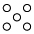

12 % complete
22 % complete
30 % complete
45 % complete
50 % complete
62 % complete
76 % complete
83 % complete
90 % complete
Target Image, window size 5


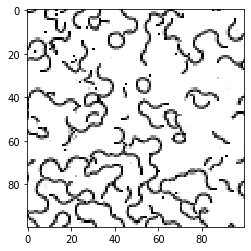

11 % complete
20 % complete
32 % complete
48 % complete
56 % complete
66 % complete
76 % complete
86 % complete
96 % complete
Target Image, window size 7


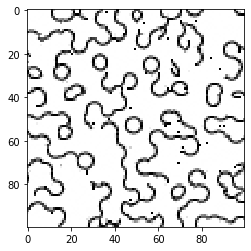

15 % complete
26 % complete
40 % complete
56 % complete
76 % complete
96 % complete
Target Image, window size 13


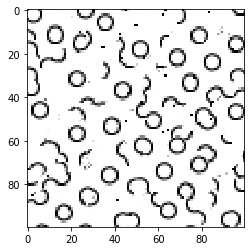

Source Image


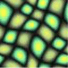

12 % complete
22 % complete
30 % complete
45 % complete
50 % complete
62 % complete
76 % complete
83 % complete
90 % complete
Target Image, window size 5


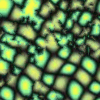

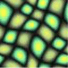

11 % complete
20 % complete
32 % complete
48 % complete
56 % complete
66 % complete
76 % complete
86 % complete
96 % complete
Target Image, window size 7


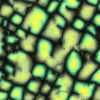

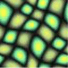

15 % complete
26 % complete
40 % complete
56 % complete
76 % complete
96 % complete
Target Image, window size 13


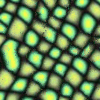

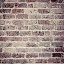

Source Image
12 % complete
22 % complete
30 % complete
45 % complete
50 % complete
62 % complete
76 % complete
83 % complete
90 % complete
Target Image, window size 5


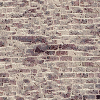

11 % complete
20 % complete
32 % complete
48 % complete
56 % complete
66 % complete
76 % complete
86 % complete
96 % complete
Target Image, window size 7


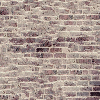

15 % complete
26 % complete
40 % complete
56 % complete
76 % complete
96 % complete
Target Image, window size 13


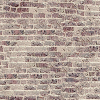

In [25]:
# Texture synthesis on rings



source = cv2.imread('rings.jpg')
window_sizes = [5, 7, 13] 
out_size = [100, 100]

print('Source Image')
cv2_imshow(source)

for w in window_sizes:
  target = synth_texture(source, w, out_size)
  print('Target Image, window size %i' %w)
  plt.imshow(target)
  plt.show()


source = cv2.imread('texture.jpg')
print('Source Image')
for w in window_sizes:
# Texture synthesis on colored image
  
  cv2_imshow(source)
  target = synth_texture(source, w, out_size)*255
  print('Target Image, window size %i'%w)
  cv2_imshow(target)


# Don't need to submit this one
source = cv2.imread('third_image.jpg')
source = cv2.resize(source, (64, 64))
cv2_imshow(source)
print('Source Image')
for w in window_sizes:
  target = synth_texture(source, w, out_size)*255
  print('Target Image, window size %i'% w)
  cv2_imshow(target)

3.2


Question:
Explain the algorithm’s performance with respect to window size. For a
given window size, if you re-run the algorithm with the same starting seed do you get the
same result? Why or why not? Is this true for all window sizes? 

Ans:
Algorithm's performance with respect to window size:
As the window size is increased, the algorithm produces textures more accurate to the original sample provided. This is because, on increasing the window size,the texture is more well defined and there are greater number of pixels to choose from. 
If the algorihm is run multiple times for with the same starting seed, without changing the window size, the resulting final images can differ. This would be because the best pixel is chosen at random (from the list of possible pixel choices returned by find_matches function)to fill holes in the final image.
On the other hand if the choice of best pixel was not random, then the resulting image would be the same. This is true for all window sizes

Question:
Also run your implementation using real color image texture.jpg and see how window size affects the performance.

As seen from the output produced as the window size is increased, the final image produced improves. However, the time to produce the final image is directly proportional to window size. i.e time for the algorithm to generate the final image also increases